# Rebalancing

In this Notwbook, two strategies on a 2-asset portfolio are discussed and compared:
- **rebalanced portfolio**, after each period
- **buy-and-hold portfolio**, without rebalancing

<!--
- [rebalanced portfolio](rebalancing:rebalanced-ptf), after each period
- [buy-and-hold portfolio](rebalancin:buy-and-hold-ptf) without rebalancing
-->

Effects of rebalancing and conditions for **rebalancing premium** are discussed: sometimes the expected log-return of the rebalanced portfolio may exceed the expected log-return of each single asset.

## Libraries, parameters and useful functions

Libraries are imported and useful functions to treat conics below are defined here

### Libraries

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

### Parameters

In [182]:
#>
params = {
    '2-asset-portfolio': { 'mu1': .10, 'sigma1': .20, 'mu2': .08, 'sigma2': .15, 'rho': -.25}
}


### Functions for conics

In [183]:
def conics_points(a,b,c,d,e,f,n=100,printout=False):
    """  ax^2 + bxy + cy^2 + dx + ey + f = 0  """
    delta = b**2 - 4*a*c
    if delta == 0.:   # possible parabola (comparison with reals?)
        ctype = 'parabola'
        x,y = np.zeros(n+1)
    elif delta < 0.:  # possible ellipse
        ctype = 'ellipse'
        x,y = ellipse_points(a,b,c,d,e,f,n,printout)
    else:             # possible hyperbola
        ctype = 'hyperbola'
        x,y = np.zeros(n+1)

    return ctype, x, y

def ellipse_points(a,b,c,d,e,f,n=100,printout=False):
    """  """
    theta = np.pi / 4. * ( a == c ) + .5 * np.atan2(b,a-c) * ( not a == c )
    if printout: print(f"theta: {theta}")
    A = a * ( np.cos(theta) )**2 + b * np.cos(theta) * np.sin(theta) + c * ( np.sin(theta) )**2
    B = ( c - a ) * np.sin(2*theta) + b * np.cos(2*theta)
    C = a * ( np.sin(theta) )**2 - b * np.cos(theta) * np.sin(theta) + c * ( np.cos(theta) )**2
    D =  d * np.cos(theta) + e * np.sin(theta)
    E = -d * np.sin(theta) + e * np.cos(theta)
    F = f

    if ( A < 0 and C < 0 ):
        A = -A; B = -B; C = -C; D = -D; E = -E; F = -F
    elif ( A == 0 )  :  raise ValueError("A = 0")
    elif ( C == 0 )  :  raise ValueError("C = 0")
    elif ( A*C < 0. ):  raise ValueError(f"A*C={A*C} <= 0")

    uc = - .5 * D / A
    vc = - .5 * E / C
    FF = A * uc**2 + C * vc**2 - F

    if printout: print(f"uc: {uc}\nvc: {vc}\nFF: {FF}")

    if FF > 0:
        if printout: print(f"A: {A}\nB: {B}\nC: {C}\nD: {D}\nE: {E}\nF: {F}")

        semi_a = np.sqrt(FF/A)
        semi_b = np.sqrt(FF/C)

        if printout: print(f"semi_a: {semi_a}\nsemi_b: {semi_b}")

        thv = np.linspace(0, 2*np.pi, n+1);  thv[-1] = thv[0]

        u, v = semi_a * np.cos(thv), semi_b * np.sin(thv)
        x = ( u + uc ) * np.cos(theta) - ( v + vc ) * np.sin(theta)
        y = ( u + uc ) * np.sin(theta) + ( v + vc ) * np.cos(theta)

        return x,y

    else:
        raise ValueError(f"FF:{FF} <= 0")

    # else: 0: degenerate ellipse; <0: not an ellipse! (what's that?)


## Rebalanced portfolio

Let the **1-period return** of the assets be normal (**todo** *is this necessary? Can't one rely on central limit theorem? How long the summation must be for convergence to normal distribution, in presence of **heavy-tails** distribution? If one can't rely on central limit theorem, let use numerical methods to investigate the effect of heavy tails distributions*),

$$\mathbf{r} \sim \mathscr{N} \left( \boldsymbol{\mu}, \boldsymbol{\sigma}^2 \right) \ .$$

Compound return of the portfolio has **expected value**

$$\mu^c_p = \mathbb{E}[r^c_p] = \mathbf{w}^T \boldsymbol{\mu} - \dfrac{1}{2}\mathbf{w}^T \boldsymbol{\sigma}^2 \, \mathbf{w}$$

and **variance**

$$\begin{aligned}
\sigma_{r^c_p}^2
& = \mathbb{E}\left[(r^c_p - \mu^c_p )^2 \right] = \dots = \mathbf{w}^T \boldsymbol{\sigma} \mathbf{w}
\end{aligned}$$



### Shannon demon

Sometimes the expected value of the compound return of the rebalanced portfolio can be larger than the expected return of each asset class.

$$\mu^c_k = \mathbb{E}[r^c_k]  = \mu_k - \dfrac{\sigma_k^2}{2}$$

**Example: 2-asset portfolio.** As an example, the expected value of the compund return of a 2-asset rebalanced portfolio,

$$\mathbb{E} [ r_p^c ] = w_1 \mu_1 + w_2 \mu_2 - \dfrac{1}{2} ( w_1^2 \sigma_1^2 + 2 w_1 w_2 \rho \sigma_1 \sigma_2 + w_2^2 \sigma_2^2 )$$


Using $w_1$, $w_2$ as independent variables, for any value of the expected return, the expression of the return itself can be represented as a **conic section** in the $w_1,w_2$-plane. In particular,
- for $\rho \ne 1$, it's an **ellipse** ($\Delta = B^2 - 4 A C < 0$),
- for $\rho = 1$, it's a **parabola** ($\Delta = 0$)

**Portfolio allocation.** Some constraints may hold on portfolio allocation:
- fully-invested: $w_1 + w_2 = 1$
- no short-selling: $w_1,\ w_2 \ge 0$
- no leverage: $w_1, \ w_2 \le 1$

In [184]:
def plot_shannon_demon_set(rho, mu1, sigma1, mu2, sigma2):
    #> Plot parameters
    xmin, xmax, nx = -10.5, 11.5, 21
    ymin, ymax, ny = -10.5, 11.5, 21

    #> Expected value of single-asset compound returns
    ElnP1 = mu1 - .5 * sigma1**2
    ElnP2 = mu2 - .5 * sigma2**2

    ElnP = max(ElnP1, ElnP2)     # Take max for comparison

    #> Define conics coefficients and find points
    a, b, c, d, e, f = -.5*sigma1**2, -rho*sigma1*sigma2, -.5*sigma2**2, mu1 ,mu2, -ElnP
    ctype, x, y = conics_points(a,b,c,d,e,f, printout=False)

    #> Plot
    print(f"max(ElnP1, ElnP2): {ElnP}")

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(x,y)
    ax.fill(x,y, alpha=.3)
    ax.plot(np.linspace(0,1), np.linspace(1,0), color='black')
    ax.grid()
    ax.set_aspect('equal') # , 'box')
    ax.set_xlim(-.5,1.5)
    ax.set_ylim(-.5,1.5)
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_2$")

#> Initial value of params
mu1    = params['2-asset-portfolio']['mu1']
sigma1 = params['2-asset-portfolio']['sigma1']
mu2    = params['2-asset-portfolio']['mu2']
sigma2 = params['2-asset-portfolio']['sigma2']
rho    = params['2-asset-portfolio']['rho']

#> Interactive plot
interact(
    plot_shannon_demon_set,
    rho=FloatSlider(   value=rho   , min=-1.0 , max=1.0, step=0.01, description='rho'),
    mu1=FloatSlider(   value=mu1   , min=-0.30, max=.30, step=0.01, description=f'mu1'),
    mu2=FloatSlider(   value=mu2   , min=-0.30, max=.30, step=0.01, description=f'mu2'),
    sigma1=FloatSlider(value=sigma1, min= .0  , max=.30, step=0.01, description=f'sig1'),
    sigma2=FloatSlider(value=sigma2, min= .0  , max=.30, step=0.01, description=f'sig2')
);

interactive(children=(FloatSlider(value=-0.25, description='rho', max=1.0, min=-1.0, step=0.01), FloatSlider(v…

This plot represents in **blue** asset allocations of the balanced 2-asset portfolio with expected value of the compound return larger than the compound return of any individual asset. **Black line** represents all the possible allocations of a fully invested portfolio, $w_1+w_2=1$ with no leaverage $w_k \le 1$ and not short selling $w_k \ge 0$.

## Comparison of portfolios: realizations of stochastic processes



In this section, rebalanced portfolio and buy-and-hold portfolio are compared.
Different realizations of these two portfolio strategies are built, and used to build statistics, and discuss their properties in terms of **compound return**, **drawdowns**,...

**Note.** Here, 1-period returns are modelled as *normal random variable* so far. Anyways, it's possible (and suggested) to implement the most suited random process for modelling the return of the desired assets.

### Useful functions

A useful function is introduced here to build correlated random variables with the desired expected values and covariance.

Main Colab notebook can be found here: https://colab.research.google.com/drive/1n5py0Zf8i3_jrTTk0AR7Noq2kBYwpaqx?authuser=1#scrollTo=gmbjbprjCHto

In [185]:
def correlated_variable_coeffs(mux, muy, sigmax, sigmay, rhoxy):
  if ( np.abs(rhoxy) > 1. ):
      raise ValueError('Invalid correlation coefficient, |rhoxy|=|{rhoxy}| > 1.')
  elif ( not rhoxy == 1. ):
      a = rhoxy * sigmay / sigmax
      sigmaz = 1.
      b = np.sqrt(sigmay**2 - a**2 * sigmax**2) / sigmaz**2
      c = 0.
      muz = (muy - c - mux * rhoxy * sigmay / sigmax) / b
  else:
      a = rhoxy * sigmay / sigmax
      muz = 0.
      sigmaz = 1.
      b = 0.
      c = muy - mux * rhoxy * sigmay / sigmax

  return muz, sigmaz, a, b, c

### Realizations

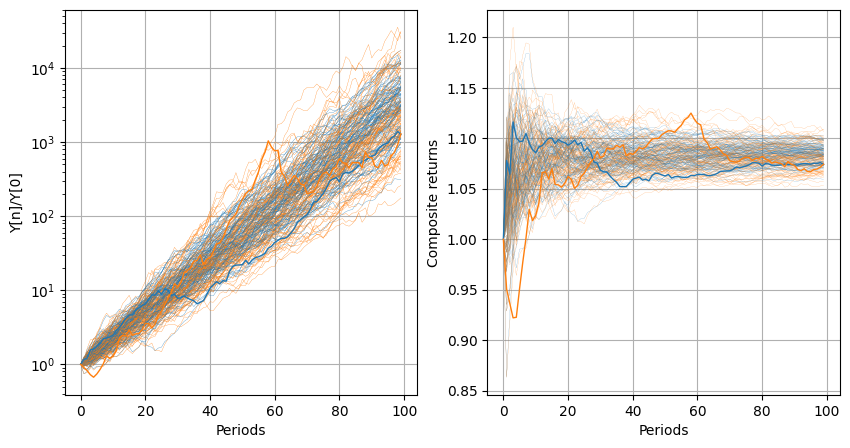

In [186]:
#> Parameters of the 2 assets
mu1    = params['2-asset-portfolio']['mu1']      #
sigma1 = params['2-asset-portfolio']['sigma1']   #
mu2    = params['2-asset-portfolio']['mu2']      #
sigma2 = params['2-asset-portfolio']['sigma2']   #
rho    = -.5 # params['2-asset-portfolio']['rho']      #

#> Evaluate the parameters of an independent r.v. Z to build the r.v. of asset 2
# with desired average value, variance and covariance with X
muz, sigmaz, a,b,c = correlated_variable_coeffs(mu1, mu2, sigma1, sigma2, rho)

#> Weights of the 2 assets
# rebalanced ptf  : constant weights
# buy-and-hold ptf: initial weights
w1, w2 = 0.5, 0.5

#> Initial conditions
y0 = 1

#> Random number generator, representing 1-period return R_n = Y_{n}/Y_{n-1}
nreal = 1000       # n. of realizations of the random process
nt = 100           # n. of periods (toss) for each realization
tv = np.arange(nt)

#> Random number generators of the 2 assets
rng1 = np.random.default_rng().normal
rng1_params = {'loc': mu1, 'scale': sigma1, 'size': nt}

rngZ = np.random.default_rng().normal
rngZ_params = {'loc': muz, 'scale': sigmaz, 'size': nt}

#> End values, max drawdowns
y_reb_end, y_bah_end = np.zeros(nreal), np.zeros(nreal)
reb_max_drawdown, bah_max_drawdown = np.zeros(nreal), np.zeros(nreal)


fig, ax = plt.subplots(1,2, figsize=(10,5))
for ireal in np.arange(nreal):

    #> 1-period returns of the 2 assets
    r1 = rng1(**rng1_params)
    rZ = rngZ(**rngZ_params)
    r2 = a*r1 + b*rZ + c

    #> Rebalanced portfolio
    y_reb = np.zeros(nt);  y_reb[0] = y0
    y_reb[1:] = y_reb[0]*np.cumprod(1 + w1*r1[1:] + w2*r2[1:])

    #> Buy-and-hold portfolio
    y_bah_1 = np.zeros(nt);  y_bah_1[0] = y0 * w1
    y_bah_2 = np.zeros(nt);  y_bah_2[0] = y0 * w2
    y_bah_1[1:] = y_bah_1[0]*np.cumprod(1+r1[1:])
    y_bah_2[1:] = y_bah_2[0]*np.cumprod(1+r2[1:])

    y_bah = y_bah_1 + y_bah_2

    #> End values
    y_reb_end[ireal] = y_reb[-1]/y0
    y_bah_end[ireal] = y_bah[-1]/y0

    #> Max drawdowns
    y_reb_max = np.maximum.accumulate(y_reb)
    y_bah_max = np.maximum.accumulate(y_bah)

    reb_drawdowns = 1. - y_reb/y_reb_max
    bah_drawdowns = 1. - y_bah/y_bah_max

    #> Update stored realization with max drawdown
    if np.max(reb_drawdowns) > np.max(reb_max_drawdown):
        y_reb_max_drawdown = y_reb.copy()
    if np.max(bah_drawdowns) > np.max(bah_max_drawdown):
        y_bah_max_drawdown = y_bah.copy()

    reb_max_drawdown[ireal] = np.max(reb_drawdowns)
    bah_max_drawdown[ireal] = np.max(bah_drawdowns)

    if ( ireal % 10 == 0 ):
        ax[0].semilogy(tv, y_reb/y_reb[0], lw=.2, color=plt.cm.tab10.colors[0])
        ax[0].semilogy(tv, y_bah/y_bah[0], lw=.2, color=plt.cm.tab10.colors[1])

        ax[1].plot(tv, ((y_reb)/y_reb[0])**(1/(tv+1)), lw=.1, color=plt.cm.tab10.colors[0])
        ax[1].plot(tv, ((y_bah)/y_bah[0])**(1/(tv+1)), lw=.1, color=plt.cm.tab10.colors[1])

ax[0].set_ylabel("Y[n]/Y[0]")
ax[0].set_xlabel("Periods")
ax[0].grid()

ax[1].set_ylabel("Composite returns")
ax[1].set_xlabel("Periods")
ax[1].grid()



ax[0].semilogy(tv, y_reb_max_drawdown/y_reb[0], lw=1, color=plt.cm.tab10.colors[0], label='Rebalanced')
ax[0].semilogy(tv, y_bah_max_drawdown/y_reb[0], lw=1, color=plt.cm.tab10.colors[1], label='Buy-and-hold')
ax[1].plot(tv, (y_reb_max_drawdown/y_reb[0])**(1/(tv+1)), lw=1, color=plt.cm.tab10.colors[0], label='Rebalanced')
ax[1].plot(tv, (y_bah_max_drawdown/y_reb[0])**(1/(tv+1)), lw=1, color=plt.cm.tab10.colors[1], label='Buy-and-hold')


#> Analytical solution
# logret = expected_logret_fun(b,a,p,f)
# ax.semilogy(tv, y0*np.exp(logret)**tv, lw=1, color=plt.cm.tab10.colors[0])
# ax.set_ylabel("Y[n]/Y[0]")
# ax.set_xlabel("Periods")
# ax.grid()



### Composite return

Rebalanced portfolio. Compsite return
 Exp. value: 0.085
 Std. dev. : 0.009
Buy-and-Hold portfolio. Compsite return
 Exp. value: 0.082
 Std. dev. : 0.012


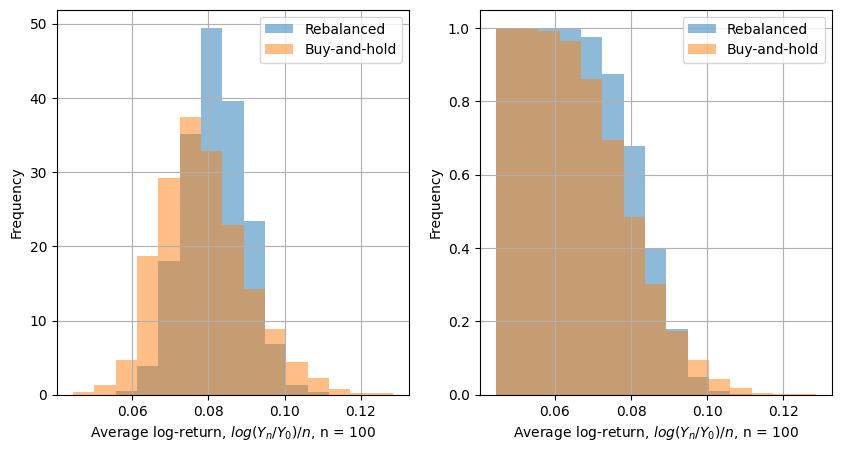

In [192]:
#> Average and variance of composite return
print("Rebalanced portfolio. Compsite return")
print(f" Exp. value: {np.mean((y_reb_end/y0)**(1/nt)-1):.3f}")
print(f" Std. dev. : {np.std( (y_reb_end/y0)**(1/nt)-1):.3f}")
print("Buy-and-Hold portfolio. Compsite return")
print(f" Exp. value: {np.mean((y_bah_end/y0)**(1/nt)-1):.3f}")
print(f" Std. dev. : {np.std( (y_bah_end/y0)**(1/nt)-1):.3f}")


fig, ax = plt.subplots(1,2, figsize=(10,5))
#> Define hist bins
min_logret = min(np.min(np.log(y_reb_end/y0)/nt), np.min(np.log(y_bah_end/y0)/nt))
max_logret = max(np.max(np.log(y_reb_end/y0)/nt), np.max(np.log(y_bah_end/y0)/nt))
nbins = 15
min_bins = min_logret - (max_logret - min_logret)/nbins
max_bins = max_logret + (max_logret - min_logret)/nbins
bins = np.linspace(min_bins, max_bins, nbins+1)

#> Loop over density and cumulative probability
cum_v = [False, -1]
for i in range(2):
    ax[i].hist(np.log(y_reb_end/y0)/nt, bins=bins, density=True, cumulative=cum_v[i], alpha=.5, label="Rebalanced")
    ax[i].hist(np.log(y_bah_end/y0)/nt, bins=bins, density=True, cumulative=cum_v[i], alpha=.5, label="Buy-and-hold")
    ax[i].set_xlabel(f"Average log-return, $log(Y_n/Y_0)/n$, n = {nt}")
    ax[i].set_ylabel("Frequency")
    ax[i].legend();  ax[i].grid()


### Maximum drawdown

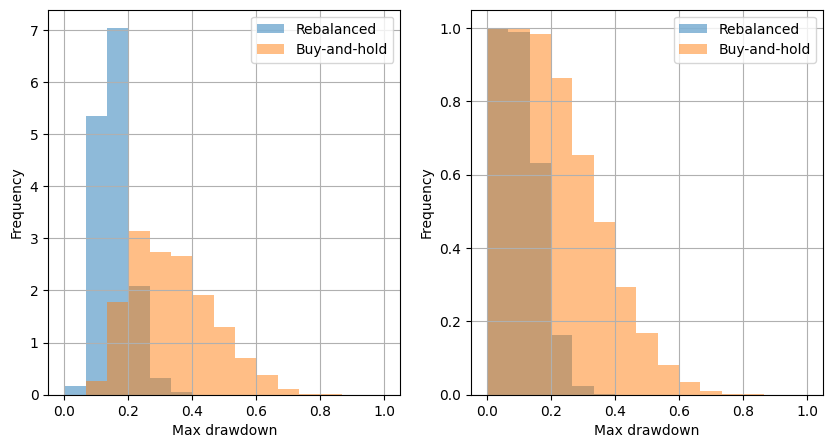

In [193]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
#> Define hist bins
# min_drawdown = min(np.min(y_reb_max_drawdown), np.min(y_bah_max_drawdown))
# max_drawdown = min(np.max(y_reb_max_drawdown), np.max(y_bah_max_drawdown))
nbins = 15
min_bins = 0.  # min_drawdown - (max_drawdown - min_drawdown)/nbins
max_bins = 1.  # max_drawdown + (max_drawdown - min_drawdown)/nbins
bins = np.linspace(min_bins, max_bins, nbins+1)
cum_v = [False, -1]
for i in range(2):
    ax[i].hist(reb_max_drawdown, bins=bins, alpha=.5, density=True, cumulative=cum_v[i], label="Rebalanced")
    ax[i].hist(bah_max_drawdown, bins=bins, alpha=.5, density=True, cumulative=cum_v[i], label="Buy-and-hold")
    ax[i].set_xlabel(f"Max drawdown")
    ax[i].set_ylabel("Frequency")
    ax[i].legend();  ax[i].grid()


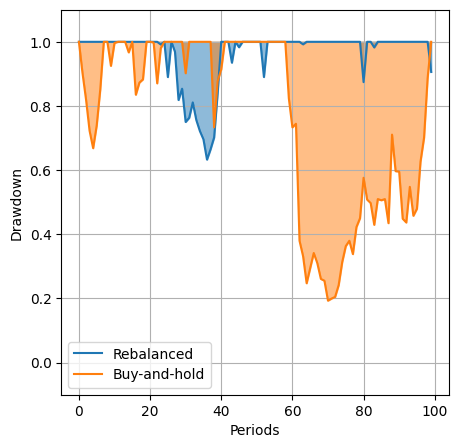

In [195]:
reb_running_max = np.maximum.accumulate(y_reb_max_drawdown)
bah_running_max = np.maximum.accumulate(y_bah_max_drawdown)

ddown_reb = 1. - y_reb_max_drawdown/reb_running_max
ddown_bah = 1. - y_bah_max_drawdown/bah_running_max

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(tv, 1.-ddown_reb, color=plt.cm.tab10.colors[0], label='Rebalanced')
ax.plot(tv, 1.-ddown_bah, color=plt.cm.tab10.colors[1], label='Buy-and-hold')
ax.fill_between(tv, 1.-ddown_reb, np.ones(nt), color=plt.cm.tab10.colors[0], alpha=.5)
ax.fill_between(tv, 1.-ddown_bah, np.ones(nt), color=plt.cm.tab10.colors[1], alpha=.5)
ax.set_xlabel("Periods")
ax.set_ylabel("Drawdown")
ax.set_ylim(-.1, 1.1)
ax.legend()
ax.grid()